<a href="https://colab.research.google.com/github/Tlen33/Text-generation/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Подключаем библиотеки

from google.colab import files
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from tensorflow.keras.optimizers import RMSprop, Adadelta
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
import numpy as np
import yaml

In [ ]:
# Подключаем диск

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Открываем файл с диалогами

corpus = open('/content/drive/MyDrive/Colab Notebooks/Базы/Диалоги(рассказы)_censored.yml', 'r')
document = yaml.safe_load(corpus)
conversations = document['разговоры']
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[123]))
corpus.close()

Количество пар вопрос-ответ : 11893
Пример диалога : ['Перезалил?', 'Да вроде бы нет...']


In [ ]:
# Разбираем вопросы-ответы

questions = list()
answers = list()

for con in conversations:
  if len(con) > 2 :
    questions.append(con[0])
    replies = con[1:]
    ans = ''
    for rep in replies:
      ans += ' ' + rep
    answers.append(ans)
  elif len(con)> 1:
    questions.append(con[0])
    answers.append(con[1])

answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i])
  else:
    questions.pop(i)

answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [ ]:
# Подключаем токенизатор

tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
vocabularyItems = list(tokenizer.word_index.items())
vocabularySize = len(vocabularyItems)+1
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('я', 5), ('а', 6), ('ты', 7), ('это', 8), ('да', 9), ('в', 10), ('нет', 11), ('как', 12), ('и', 13), ('вы', 14), ('ну', 15), ('с', 16), ('на', 17), ('же', 18), ('так', 19), ('он', 20), ('у', 21), ('кто', 22), ('где', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('здесь', 30), ('еще', 31), ('почему', 32), ('о', 33), ('тебе', 34), ('там', 35), ('есть', 36), ('его', 37), ('за', 38), ('куда', 39), ('вот', 40), ('ничего', 41), ('вас', 42), ('знаю', 43), ('чем', 44), ('но', 45), ('она', 46), ('они', 47), ('ли', 48), ('чего', 49), ('вам', 50)]
Размер словаря : 15092


In [ ]:
# Устанавливаем закодированные вопросы

tokenizedQuestions = tokenizer.texts_to_sequences(questions)
maxLenQuestions = max([ len(x) for x in tokenizedQuestions])
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

encoderForInput = paddedQuestions
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 

Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 170   18 5703    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11888, 11)
Установленная длина вопросов на вход : 11


In [ ]:
# Устанавливаем раскодированные ответы

tokenizedAnswers = tokenizer.texts_to_sequences(answers)
maxLenAnswers = max([len(x) for x in tokenizedAnswers])
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

decoderForInput = paddedAnswers
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[200])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [   1 1743    2    0    0    0    0    0    0    0    0    0    0]
Размеры раскодированного массива ответов на вход : (11888, 13)
Установленная длина ответов на вход : 13


In [ ]:
# Раскодированные ответы

tokenizedAnswers = tokenizer.texts_to_sequences(answers)
for i in range(len(tokenizedAnswers)):
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize)
decoderForOutput = np.array(oneHotAnswers)

print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    1   672    19    93 10547     2     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11888, 13, 15092)
Установленная длина вопросов на выход : 13


In [ ]:
# Первый входной слой, кодер, выходной слой

encoderInputs = Input(shape=(None , ))
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
# Второй входной слой, декодер, выходной слой

decoderInputs = Input(shape=(None, ))
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 200)    3018400     ['input_29[0][0]']               
                                                                                                  
 embedding_7 (Embedding)        (None, None, 200)    3018400     ['input_30[0][0]']               
                                                                                           

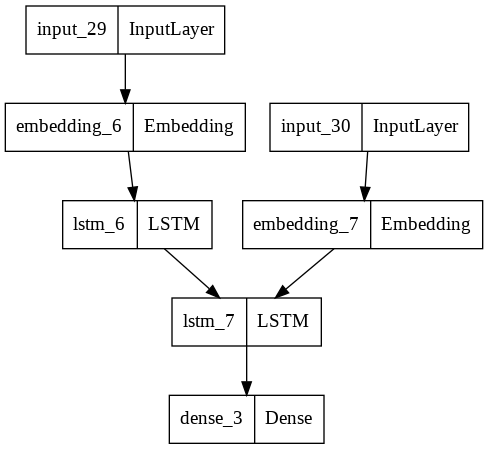

In [ ]:
# Тренировочная модель нейронки

model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary())
plot_model(model, to_file='model.png')

In [ ]:
# Запустим обучение и сохраним модель

model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=10) 
model.save( '/content/drive/MyDrive/Colab Notebooks/Базы/Предобученные сети/model_10epochs(rms).h5' )

Epoch 1/10
238/238 [==============================] - 41s 140ms/step - loss: 2.2152
Epoch 2/10
238/238 [==============================] - 33s 141ms/step - loss: 1.9758
Epoch 3/10
238/238 [==============================] - 33s 139ms/step - loss: 1.9263
Epoch 4/10
238/238 [==============================] - 33s 139ms/step - loss: 1.8868
Epoch 5/10
238/238 [==============================] - 34s 141ms/step - loss: 1.8521
Epoch 6/10
238/238 [==============================] - 34s 141ms/step - loss: 1.8194
Epoch 7/10
238/238 [==============================] - 33s 138ms/step - loss: 1.7885
Epoch 8/10
238/238 [==============================] - 35s 149ms/step - loss: 1.7570
Epoch 9/10
238/238 [==============================] - 33s 139ms/step - loss: 1.7227
Epoch 10/10
238/238 [==============================] - 33s 139ms/step - loss: 1.6912


In [ ]:
model.compile(optimizer=Adadelta(), loss='categorical_crossentropy')

In [ ]:
# Запустим обучение и сохраним модель на 20 эпох

model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=20) 
model.save( '/content/drive/MyDrive/Colab Notebooks/Базы/Предобученные сети/model_20epochs(rms).h5' )

Epoch 1/20
238/238 [==============================] - 38s 124ms/step - loss: 1.6270
Epoch 2/20
238/238 [==============================] - 30s 125ms/step - loss: 1.6263
Epoch 3/20
238/238 [==============================] - 29s 123ms/step - loss: 1.6258
Epoch 4/20
238/238 [==============================] - 31s 130ms/step - loss: 1.6252
Epoch 5/20
238/238 [==============================] - 30s 126ms/step - loss: 1.6247
Epoch 6/20
238/238 [==============================] - 29s 123ms/step - loss: 1.6243
Epoch 7/20
238/238 [==============================] - 29s 124ms/step - loss: 1.6239
Epoch 8/20
238/238 [==============================] - 29s 123ms/step - loss: 1.6235
Epoch 9/20
238/238 [==============================] - 29s 123ms/step - loss: 1.6232
Epoch 10/20
238/238 [==============================] - 29s 121ms/step - loss: 1.6228
Epoch 11/20
238/238 [==============================] - 30s 125ms/step - loss: 1.6225
Epoch 12/20
238/238 [==============================] - 29s 123ms/step - lo

In [ ]:
# Создаем рабочую модель для вывода ответов на запросы

def makeInferenceModels():
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,))
  decoderStateInput_c = Input(shape=(200 ,))

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]

  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c]
  decoderOutputs = decoderDense(decoderOutputs)

  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

def strToTokens(sentence: str):
  words = sentence.lower().split()
  tokensList = list()
  for word in words:
    tokensList.append(tokenizer.word_index[word])

  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
# Устанавливаем окончательные настройки и запускаем модель

encModel , decModel = makeInferenceModels()

for _ in range(3):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']

  stopCondition = False
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax( decOutputs[0, 0, :])
    sampledWord = None
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index:
        decodedTranslation += ' {}'.format(word)
        sampledWord = word

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True

    emptyTargetSeq[0, 0] = sampledWordIndex
    statesValues = [h, c]
  
  print(decodedTranslation[:-3])

Задайте вопрос : как дела
 да 
Задайте вопрос : чем занят
 да сэр 
Задайте вопрос : будешь пить
 что 


In [ ]:
# Запустим обучение и сохраним модель на +30 эпох

model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=30) 
model.save( '/content/drive/MyDrive/Colab Notebooks/Базы/Предобученные сети/model_20epochs(rms)+30.h5' )

Epoch 1/30
238/238 [==============================] - 28s 116ms/step - loss: 1.6201
Epoch 2/30
238/238 [==============================] - 28s 116ms/step - loss: 1.6199
Epoch 3/30
238/238 [==============================] - 28s 116ms/step - loss: 1.6197
Epoch 4/30
238/238 [==============================] - 27s 115ms/step - loss: 1.6195
Epoch 5/30
238/238 [==============================] - 27s 114ms/step - loss: 1.6193
Epoch 6/30
238/238 [==============================] - 28s 117ms/step - loss: 1.6191
Epoch 7/30
238/238 [==============================] - 28s 118ms/step - loss: 1.6190
Epoch 8/30
238/238 [==============================] - 28s 117ms/step - loss: 1.6188
Epoch 9/30
238/238 [==============================] - 27s 115ms/step - loss: 1.6186
Epoch 10/30
238/238 [==============================] - 28s 116ms/step - loss: 1.6185
Epoch 11/30
238/238 [==============================] - 28s 117ms/step - loss: 1.6183
Epoch 12/30
238/238 [==============================] - 28s 116ms/step - lo

In [ ]:
# Устанавливаем окончательные настройки и запускаем модель

encModel , decModel = makeInferenceModels()

for _ in range(3):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']

  stopCondition = False
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax( decOutputs[0, 0, :])
    sampledWord = None
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index:
        decodedTranslation += ' {}'.format(word)
        sampledWord = word

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True

    emptyTargetSeq[0, 0] = sampledWordIndex
    statesValues = [h, c]
  
  print(decodedTranslation[:-3])

Задайте вопрос : как дела
 да 
Задайте вопрос : чем занят
 да сэр 
Задайте вопрос : будешь пить
 что 


In [ ]:
# Запустим обучение и сохраним модель на +50 эпох

model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50) 
model.save( '/content/drive/MyDrive/Colab Notebooks/Базы/Предобученные сети/model_20epochs(rms)+30+50.h5' )

Epoch 1/50
238/238 [==============================] - 28s 119ms/step - loss: 1.6156
Epoch 2/50
238/238 [==============================] - 29s 121ms/step - loss: 1.6155
Epoch 3/50
238/238 [==============================] - 29s 121ms/step - loss: 1.6154
Epoch 4/50
238/238 [==============================] - 30s 127ms/step - loss: 1.6153
Epoch 5/50
238/238 [==============================] - 29s 120ms/step - loss: 1.6152
Epoch 6/50
238/238 [==============================] - 28s 120ms/step - loss: 1.6150
Epoch 7/50
238/238 [==============================] - 29s 123ms/step - loss: 1.6149
Epoch 8/50
238/238 [==============================] - 29s 122ms/step - loss: 1.6148
Epoch 9/50
238/238 [==============================] - 29s 120ms/step - loss: 1.6147
Epoch 10/50
238/238 [==============================] - 30s 124ms/step - loss: 1.6146
Epoch 11/50
238/238 [==============================] - 28s 119ms/step - loss: 1.6145
Epoch 12/50
238/238 [==============================] - 28s 119ms/step - lo

In [ ]:
# Устанавливаем окончательные настройки и запускаем модель

encModel , decModel = makeInferenceModels()

for _ in range(3):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']

  stopCondition = False
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax( decOutputs[0, 0, :])
    sampledWord = None
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index:
        decodedTranslation += ' {}'.format(word)
        sampledWord = word

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True

    emptyTargetSeq[0, 0] = sampledWordIndex
    statesValues = [h, c]
  
  print(decodedTranslation[:-3])

Задайте вопрос : как дела
 да 
Задайте вопрос : чем занят
 да сэр 
Задайте вопрос : будешь пить
 что 
